In [ ]:
import pandas as pd

# Load your dataset
# Replace 'your_dataset.csv' with the path to your dataset
data = pd.read_csv('/content/Parkinson final.csv')

# Split the data into training and testing sets
train_data = data[(data['subject#'] >= 1) & (data['subject#'] <= 32)]

# Select 4 rows from each subject 33 to 42 for training
extra_train_data = data[(data['subject#'] >= 33) & (data['subject#'] <= 42)].groupby('subject#').head(6)
train_data = pd.concat([train_data, extra_train_data])

# Select all data from subject 33 to 42 for testing
test_data = data[(data['subject#'] >= 33) & (data['subject#'] <= 42)]

# Save the split datasets to new CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

print("Training and testing datasets created successfully.")


Training and testing datasets created successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
import lightgbm as lgb

# Load the dataset
df = pd.read_csv('/content/train_data.csv')

# Define conditions for classification
def classify_motor(value):
    if value >= 0 and value <= 7:
        return 0  # normal
    elif value > 7 and value <= 19:
        return 1  # mild1
    elif value > 19 and value <= 25:
        return 2  # mild2
    elif value > 25:
        return 3  # severe

def classify_total(value):
    if value >= 0 and value <= 6:
        return 0  # normal
    elif value > 6 and value <= 21:
        return 1  # mild1
    elif value > 21 and value <= 31:
        return 2  # mild2
    elif value > 31:
        return 3  # severe

# Create classification labels
df['motor_UPDRS_class'] = df['motor_UPDRS'].apply(classify_motor)
df['total_UPDRS_class'] = df['total_UPDRS'].apply(classify_total)

# Features and targets
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'motor_UPDRS_class', 'total_UPDRS_class'])
y_motor_reg = df['motor_UPDRS']
y_total_reg = df['total_UPDRS']
y_motor_class = df['motor_UPDRS_class']
y_total_class = df['total_UPDRS_class']

# Train-test split
X_train, X_test, y_motor_reg_train, y_motor_reg_test, y_total_reg_train, y_total_reg_test, y_motor_class_train, y_motor_class_test, y_total_class_train, y_total_class_test = train_test_split(
    X, y_motor_reg, y_total_reg, y_motor_class, y_total_class, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN (assuming 1D data)
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define the improved CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(64, kernel_size=2, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(4, activation='softmax'))  # 4 classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_cnn, y_motor_class_train, epochs=100, batch_size=32, validation_data=(X_test_cnn, y_motor_class_test))

# Predict classification using CNN
y_motor_class_train_pred = cnn_model.predict(X_train_cnn)
y_motor_class_train_pred = np.argmax(y_motor_class_train_pred, axis=1)
y_motor_class_test_pred = cnn_model.predict(X_test_cnn)
y_motor_class_test_pred = np.argmax(y_motor_class_test_pred, axis=1)

# Add the classification results as features
X_train_with_class = np.hstack((X_train_scaled, y_motor_class_train_pred.reshape(-1, 1)))
X_test_with_class = np.hstack((X_test_scaled, y_motor_class_test_pred.reshape(-1, 1)))

# Train LGBM for regression with additional classification feature
lgb_motor_model = lgb.LGBMRegressor()
lgb_motor_model.fit(X_train_with_class, y_motor_reg_train)

lgb_total_model = lgb.LGBMRegressor()
lgb_total_model.fit(X_train_with_class, y_total_reg_train)

# Predict regression using LGBM
y_motor_reg_pred = lgb_motor_model.predict(X_test_with_class)
y_total_reg_pred = lgb_total_model.predict(X_test_with_class)

# Classification metrics
motor_class_accuracy = accuracy_score(y_motor_class_test, y_motor_class_test_pred)
motor_class_precision = precision_score(y_motor_class_test, y_motor_class_test_pred, average='weighted')
motor_class_recall = recall_score(y_motor_class_test, y_motor_class_test_pred, average='weighted')
motor_class_f1 = f1_score(y_motor_class_test, y_motor_class_test_pred, average='weighted')

print(f"Motor UPDRS Classification - Accuracy: {motor_class_accuracy}, Precision: {motor_class_precision}, Recall: {motor_class_recall}, F1 Score: {motor_class_f1}")

# Regression metrics
motor_r2 = r2_score(y_motor_reg_test, y_motor_reg_pred)
motor_mae = mean_absolute_error(y_motor_reg_test, y_motor_reg_pred)
total_r2 = r2_score(y_total_reg_test, y_total_reg_pred)
total_mae = mean_absolute_error(y_total_reg_test, y_total_reg_pred)

print(f"Motor UPDRS Regression - R²: {motor_r2}, MAE: {motor_mae}")
print(f"Total UPDRS Regression - R²: {total_r2}, MAE: {total_mae}")

# Example of predicting new input
new_input = np.array([X_test_with_class[0]])  # Example new input

# Predict classification for new input
new_input_cnn = new_input[:, :-1].reshape(new_input.shape[0], new_input.shape[1] - 1, 1)
new_motor_class_pred = cnn_model.predict(new_input_cnn)
new_motor_class_pred = np.argmax(new_motor_class_pred, axis=1)

# Predict regression for new input
new_motor_reg_pred = lgb_motor_model.predict(new_input)
new_total_reg_pred = lgb_total_model.predict(new_input)

print(f"Classification Prediction (Motor UPDRS): {new_motor_class_pred}")
print(f"Regression Prediction (Motor UPDRS): {new_motor_reg_pred}")
print(f"Regression Prediction (Total UPDRS): {new_total_reg_pred}")

# Print the actual values for the new input
print(f"Actual Motor UPDRS class: {y_motor_class_test.iloc[0]}")
print(f"Actual Motor UPDRS value: {y_motor_reg_test.iloc[0]}")
print(f"Actual Total UPDRS value: {y_total_reg_test.iloc[0]}")

# Apply the model on new datasets
new_df = pd.read_csv('/content/test_data.csv')  # Load new dataset
new_df['motor_UPDRS_class'] = new_df['motor_UPDRS'].apply(classify_motor)
new_df['total_UPDRS_class'] = new_df['total_UPDRS'].apply(classify_total)

# Prepare new data for predictions
X_new = new_df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'motor_UPDRS_class', 'total_UPDRS_class'])
y_new_motor_reg = new_df['motor_UPDRS']
y_new_total_reg = new_df['total_UPDRS']
y_new_motor_class = new_df['motor_UPDRS_class']
y_new_total_class = new_df['total_UPDRS_class']

# Normalize the new data
X_new_scaled = scaler.transform(X_new)

# Reshape for CNN
X_new_cnn = X_new_scaled.reshape(X_new_scaled.shape[0], X_new_scaled.shape[1], 1)

# Predict classification and regression on new data
y_new_motor_class_pred = cnn_model.predict(X_new_cnn)
y_new_motor_class_pred = np.argmax(y_new_motor_class_pred, axis=1)

# Add the new classification results as features
X_new_with_class = np.hstack((X_new_scaled, y_new_motor_class_pred.reshape(-1, 1)))

y_new_motor_reg_pred = lgb_motor_model.predict(X_new_with_class)
y_new_total_reg_pred = lgb_total_model.predict(X_new_with_class)

# Print predictions and actual values for new data
print(f"New Classification Predictions (Motor UPDRS): {y_new_motor_class_pred}")
print(f"New Regression Predictions (Motor UPDRS): {y_new_motor_reg_pred}")
print(f"New Regression Predictions (Total UPDRS): {y_new_total_reg_pred}")

# Print actual values for comparison
print(f"Actual New Motor UPDRS class: {y_new_motor_class.iloc[:5].values}")  # Displaying first 5 values for brevity


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4025 - loss: 1.6951 - val_accuracy: 0.4507 - val_loss: 1.2622
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5562 - loss: 1.0770 - val_accuracy: 0.5280 - val_loss: 1.1462
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6041 - loss: 0.9398 - val_accuracy: 0.6289 - val_loss: 0.8895
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6499 - loss: 0.8436 - val_accuracy: 0.7186 - val_loss: 0.7273
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6767 - loss: 0.7755 - val_accuracy: 0.7399 - val_loss: 0.6469
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6802 - loss: 0.7655 - val_accuracy: 0.7500 - val_loss: 0.5890
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7131 - loss: 0.6907 - val_accuracy: 0.7578 - val_loss: 0.5675
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7153 - loss: 0.6875 - val_accu

In [ ]:
# prompt: print the regresssion results

print(f"Motor UPDRS Regression - R²: {motor_r2}, MAE: {motor_mae}")
print(f"Total UPDRS Regression - R²: {total_r2}, MAE: {total_mae}")


Motor UPDRS Regression - R²: 0.9745287629862349, MAE: 0.6101377382547104
Total UPDRS Regression - R²: 0.9763684439388433, MAE: 0.7479493677301046


Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8937 - loss: 0.2888 - val_accuracy: 0.9372 - val_loss: 0.1521
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9035 - loss: 0.2526 - val_accuracy: 0.9361 - val_loss: 0.1379
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9075 - loss: 0.2587 - val_accuracy: 0.9428 - val_loss: 0.1377
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9011 - loss: 0.2448 - val_accuracy: 0.9439 - val_loss: 0.1435
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9053 - loss: 0.2433 - val_accuracy: 0.9439 - val_loss: 0.1450
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8982 - loss: 0.2436 - val_accuracy: 0.9451 - val_loss: 0.1353
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9032 - loss: 0.2466 - val_accuracy: 0.9563 - val_loss: 0.1369
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9094 - loss: 0.2368 - val_accu

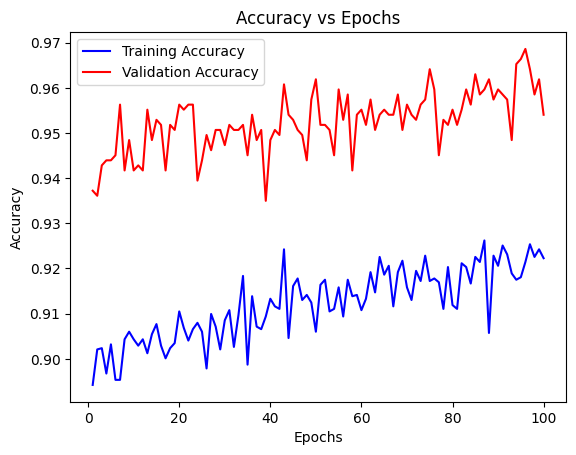

In [ ]:
# prompt: Draw Accuracy vs Epoch graphs

import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()
history = cnn_model.fit(X_train_cnn, y_motor_class_train, epochs=100, batch_size=32, validation_data=(X_test_cnn, y_motor_class_test)) # Ensure model is fit and history is recorded in the same cell

# Extract accuracy and validation accuracy from the history object
# Replace 'accuracy' and 'val_accuracy' with the actual keys in your history object
train_accuracy = history.history['accuracy'] # Access history from the history object
val_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the accuracy vs epochs
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 19, 32)              │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 19, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 8, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,774 (444.43 KB)

 Trainable params: 37,860 (147.89 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 75,722 (295.79 KB)

In [ ]:
print("Motor UPDRS Classification Metrics:")
print(f"Accuracy: {motor_class_accuracy}")
print(f"Precision: {motor_class_precision}")
print(f"Recall: {motor_class_recall}")
print(f"F1 Score: {motor_class_f1}")

print("\nMotor UPDRS Regression Metrics:")
print(f"R²: {motor_r2}")
print(f"MAE: {motor_mae}")

print("\nTotal UPDRS Regression Metrics:")
print(f"R²: {total_r2}")
print(f"MAE: {total_mae}")


Motor UPDRS Classification Metrics:
Accuracy: 0.9394618834080718
Precision: 0.940662316232138
Recall: 0.9394618834080718
F1 Score: 0.9395550006902533

Motor UPDRS Regression Metrics:
R²: 0.9745287629862349
MAE: 0.6101377382547104

Total UPDRS Regression Metrics:
R²: 0.9763684439388433
MAE: 0.7479493677301046


In [ ]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.9 MB/s eta 0:00:00


In [ ]:
# prompt: calculate the accuracy of the CNN classification model

from sklearn.metrics import accuracy_score

# Assuming y_motor_class_test_pred is the predicted labels from your CNN model
# And y_motor_class_test is the true labels from your test set

motor_class_accuracy = accuracy_score(y_motor_class_test, y_motor_class_test_pred)
print(f"Accuracy: {motor_class_accuracy}")


Accuracy: 0.9394618834080718


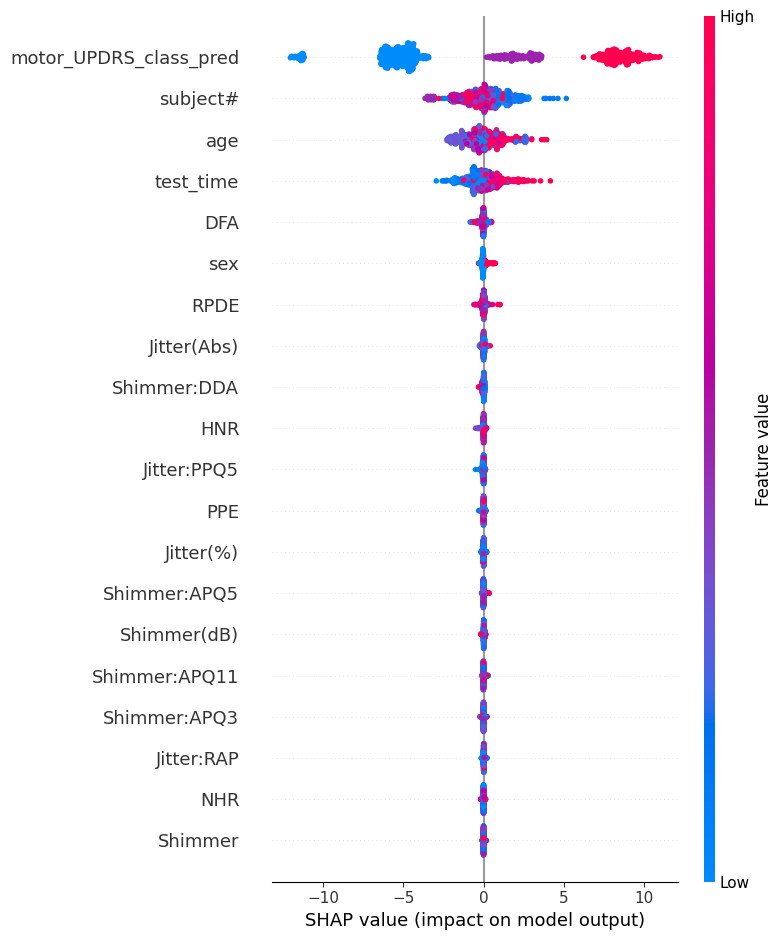

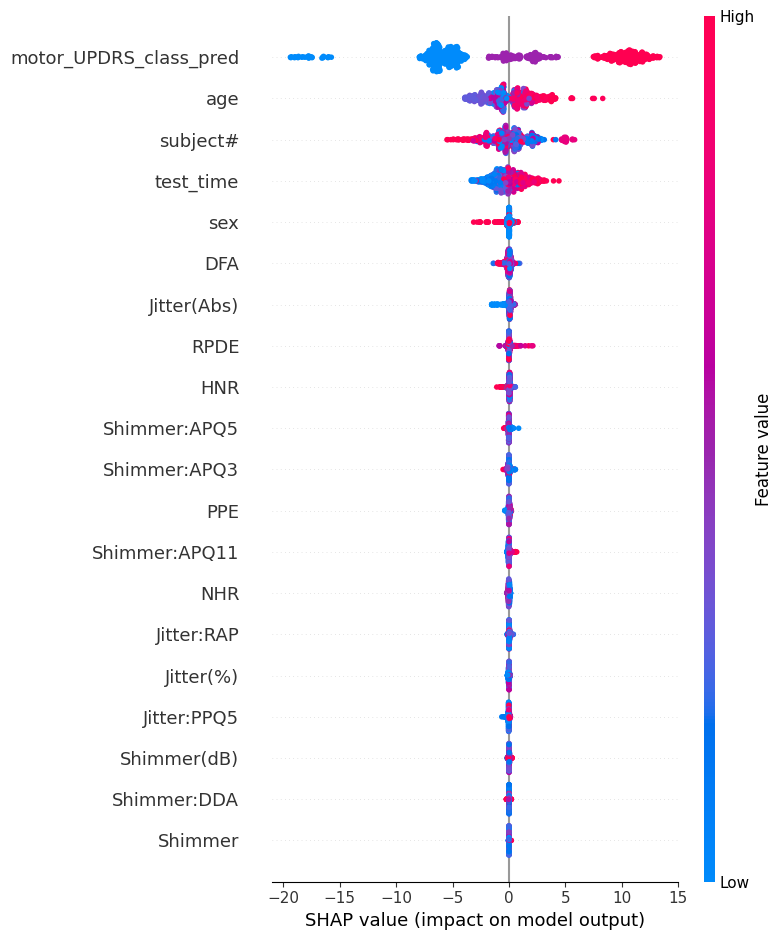

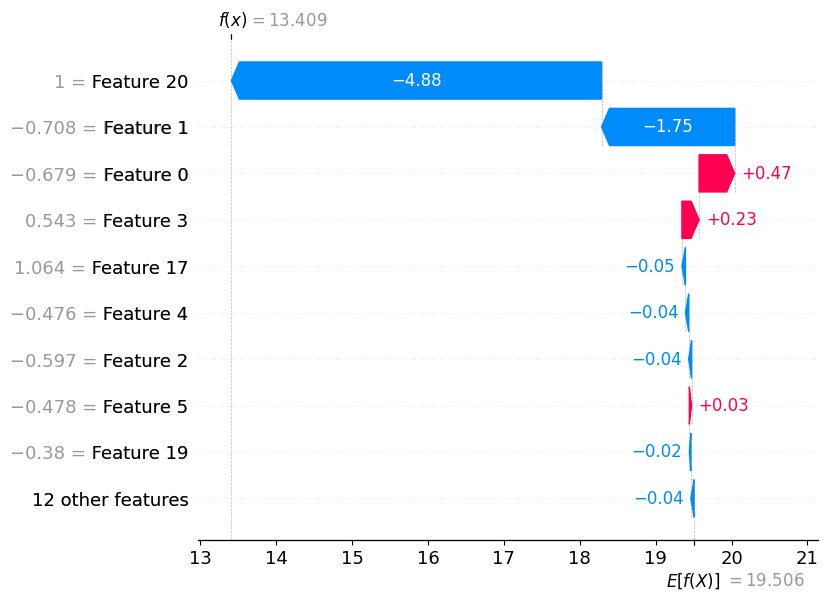

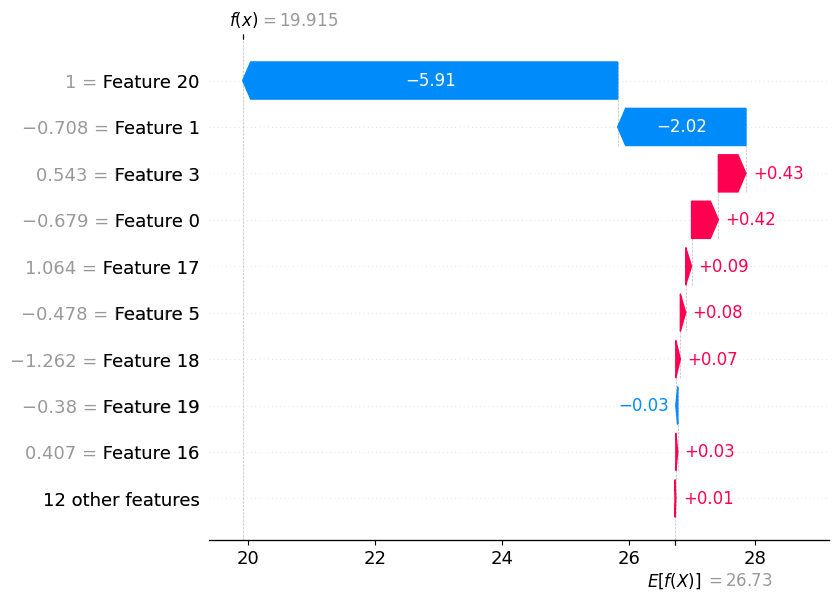

In [ ]:
import shap

# Initialize the SHAP explainer for the LightGBM model
explainer_motor = shap.Explainer(lgb_motor_model)
explainer_total = shap.Explainer(lgb_total_model)

# Compute SHAP values for the test set
shap_values_motor = explainer_motor(X_test_with_class)
shap_values_total = explainer_total(X_test_with_class)
# Plot the SHAP summary plot for Motor UPDRS predictions
shap.summary_plot(shap_values_motor, X_test_with_class, feature_names=list(X.columns) + ['motor_UPDRS_class_pred'])

# Plot the SHAP summary plot for Total UPDRS predictions
shap.summary_plot(shap_values_total, X_test_with_class, feature_names=list(X.columns) + ['motor_UPDRS_class_pred'])
# Explain a single prediction for Motor UPDRS
shap.plots.waterfall(shap_values_motor[0])

# Explain a single prediction for Total UPDRS
shap.plots.waterfall(shap_values_total[0])


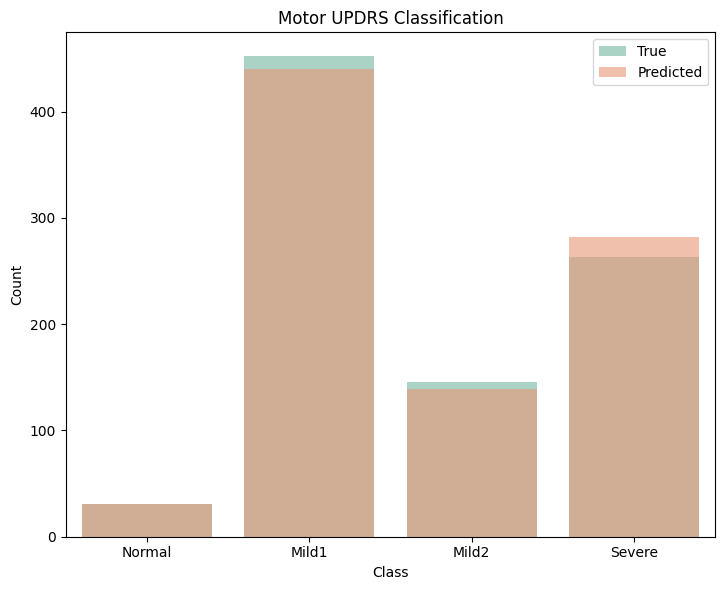

<ipython-input-9-e3ce28bf245e>:46: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


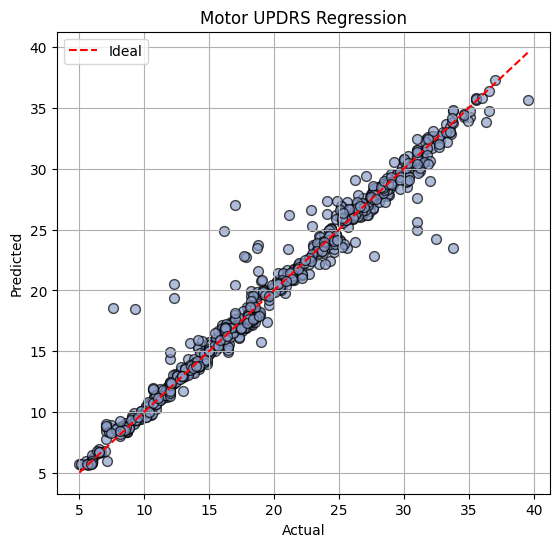

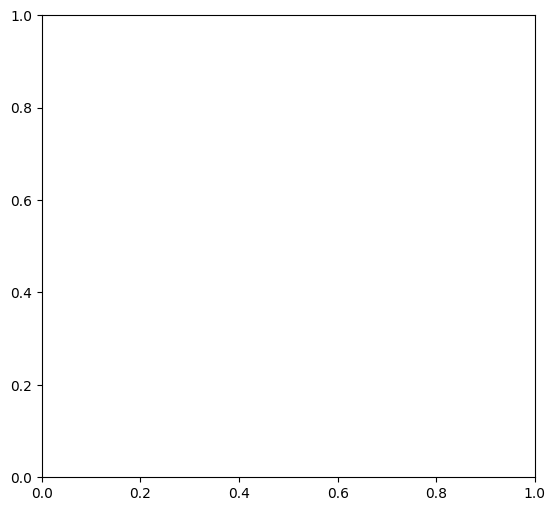

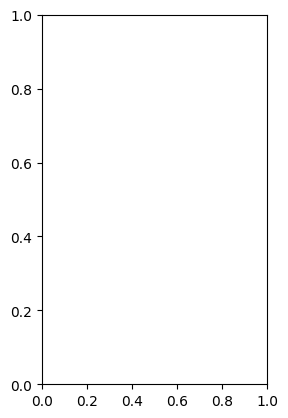

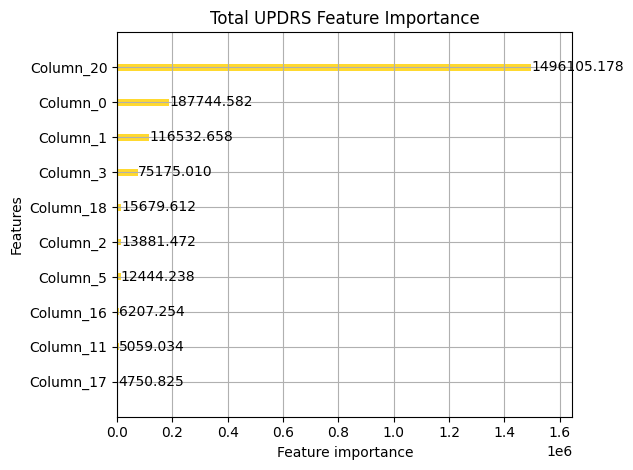

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a color palette for the plots
palette = sns.color_palette("Set2")

# Plot classification results
plt.figure(figsize=(14, 6))

# Plot motor UPDRS classification results
plt.subplot(1, 2, 1)
sns.countplot(x=y_motor_class_test, color=palette[0], label='True', alpha=0.6)
sns.countplot(x=y_motor_class_test_pred, color=palette[1], label='Predicted', alpha=0.6)
plt.title('Motor UPDRS Classification')
plt.legend()
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Normal', 'Mild1', 'Mild2', 'Severe'])

plt.tight_layout()
plt.show()

# Plot regression results
plt.figure(figsize=(14, 6))

# Plot motor UPDRS regression results
plt.subplot(1, 2, 1)
plt.scatter(y_motor_reg_test, y_motor_reg_pred, color=palette[2], alpha=0.7, edgecolor='k', s=50)
plt.plot([y_motor_reg_test.min(), y_motor_reg_test.max()], [y_motor_reg_test.min(), y_motor_reg_test.max()], 'r--', label='Ideal')
plt.title('Motor UPDRS Regression')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid(True)


# Plot the feature importance for the LGBM models
plt.figure(figsize=(14, 6))

# Plot feature importance for motor UPDRS regression
plt.subplot(1, 2, 1)
lgb.plot_importance(lgb_motor_model, max_num_features=10, importance_type='gain', title='Motor UPDRS Feature Importance', color=palette[4])
plt.title('Motor UPDRS Feature Importance')

# Plot feature importance for total UPDRS regression
plt.subplot(1, 2, 2)
lgb.plot_importance(lgb_total_model, max_num_features=10, importance_type='gain', title='Total UPDRS Feature Importance', color=palette[5])
plt.title('Total UPDRS Feature Importance')

plt.tight_layout()
plt.show()


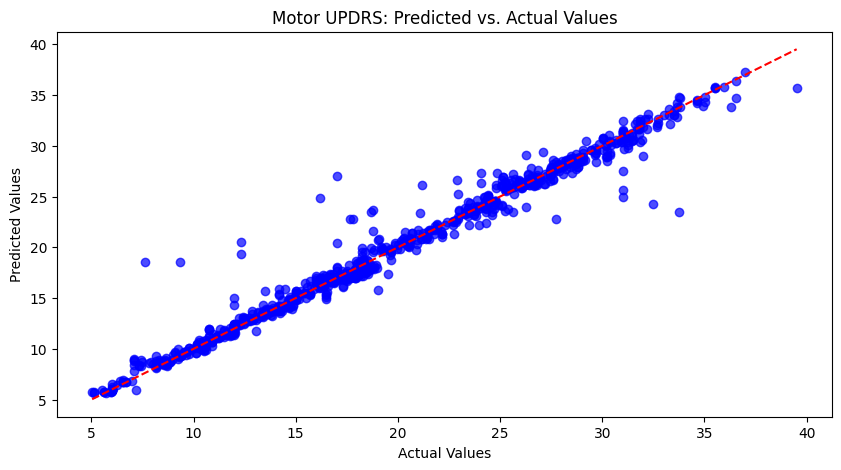

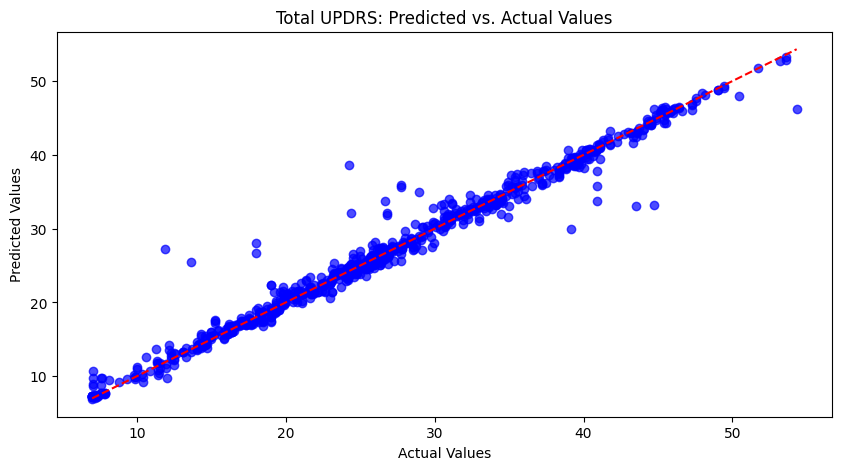

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for Motor UPDRS
plt.figure(figsize=(10, 5))
plt.scatter(y_motor_reg_test, y_motor_reg_pred, alpha=0.7, color='b')
plt.plot([min(y_motor_reg_test), max(y_motor_reg_test)], [min(y_motor_reg_test), max(y_motor_reg_test)], color='r', linestyle='--')
plt.title('Motor UPDRS: Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Scatter plot for Total UPDRS
plt.figure(figsize=(10, 5))
plt.scatter(y_total_reg_test, y_total_reg_pred, alpha=0.7, color='b')
plt.plot([min(y_total_reg_test), max(y_total_reg_test)], [min(y_total_reg_test), max(y_total_reg_test)], color='r', linestyle='--')
plt.title('Total UPDRS: Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


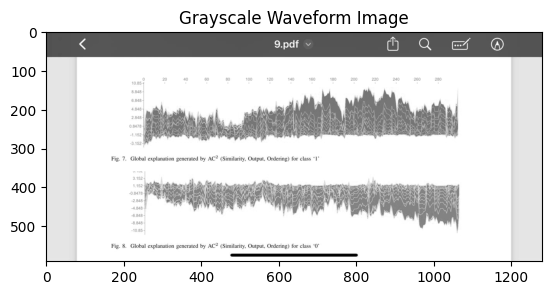

Jitter (%): 3.3938057922336715
Jitter (RAP): 0.2659201922892962
Jitter (PPQ5): 0.8855888819940155
Jitter (DDP): 0.4818380931560508


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/WhatsApp Image 2024-07-17 at 14.21.14_f7eea066.jpg'  # Change the path to the correct image file
image = Image.open(image_path)

# Convert image to numpy array
image_data = np.array(image)

# Convert the image to grayscale (for easier processing, if needed)
gray_image = np.mean(image_data[:, :, :3], axis=2)

# Convert the image to grayscale (for easier processing, if needed)
gray_image = np.mean(image_data[:, :, :3], axis=2)

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Waveform Image')
plt.show()

# Apply a threshold to isolate the waveform line
threshold = 100  # Adjust based on the image
binary_image = gray_image < threshold

# Get the height and width of the image
height, width = binary_image.shape

# Initialize arrays to store feature values
jitter_percentages = []

# Extract the y-coordinates of the waveform line for each x-coordinate
for x in range(width):
    y_coords = np.where(binary_image[:, x])[0]
    if len(y_coords) > 1:
        # Compute jitter (local) - standard deviation of y-coordinates
        jitter_local = np.std(np.diff(y_coords))
        jitter_percentages.append(jitter_local / height)  # Store jitter as a percentage of image height


# Calculate mean jitter and shimmer across all x-coordinates
mean_jitter_percentage = np.mean(jitter_percentages) * 100

# Extract the y-coordinates of the waveform line for each x-coordinate
y_coords = []
for x in range(width):
    y = np.where(binary_image[:, x])[0]
    if len(y) > 0:
        y_coords.append(np.mean(y))

y_coords = np.array(y_coords)

# Print extracted features
print(f"Jitter (%): {mean_jitter_percentage}")

# Jitter (RAP)
jitter_rap = np.mean(np.abs(np.diff(y_coords, n=2)) / y_coords[1:-1])
print(f"Jitter (RAP): {jitter_rap}")

# Jitter (PPQ5)
jitter_ppq5 = np.mean(np.abs(np.diff(y_coords, n=4)) / y_coords[2:-2])
print(f"Jitter (PPQ5): {jitter_ppq5}")

# Jitter (DDP)
jitter_ddp = np.mean(np.abs(np.diff(y_coords, n=3)) / y_coords[1:-2])
print(f"Jitter (DDP): {jitter_ddp}")

In [ ]:
waveform = (image_data[height//2, :] / 255.0) * 2 - 1  # Normalize to -1 to 1
import librosa
import librosa.display
# Step 3: Assume a sample rate
sample_rate = 22050  # This may need adjustment based on your specific data

# Step 4: Calculate features using librosa and other methods where necessary

# Shimmer calculation
def calculate_shimmer(waveform):
    shimmer = np.std(np.abs(waveform))
    shimmer_apq3 = np.mean(np.abs(waveform[3:] - waveform[:-3]))
    shimmer_apq5 = np.mean(np.abs(waveform[5:] - waveform[:-5]))
    shimmer_apq11 = np.mean(np.abs(waveform[11:] - waveform[:-11]))
    shimmer_dda = np.mean(np.abs(waveform[2:] - waveform[:-2]))
    return shimmer, shimmer_apq3, shimmer_apq5, shimmer_apq11, shimmer_dda


# Calculate shimmer
shimmer, shimmer_apq3, shimmer_apq5, shimmer_apq11, shimmer_dda = calculate_shimmer(waveform)

# Print extracted features
print("Extracted features:")
print(f"Shimmer: {shimmer}")
print(f"Shimmer:APQ3: {shimmer_apq3}")
print(f"Shimmer:APQ5: {shimmer_apq5}")
print(f"Shimmer:APQ11: {shimmer_apq11}")
print(f"Shimmer:DDA: {shimmer_dda}")

Extracted features:
Shimmer: 0.07519661057592777
Shimmer:APQ3: 0.0046473300883914
Shimmer:APQ5: 0.006200692041522492
Shimmer:APQ11: 0.00913899576116236
Shimmer:DDA: 0.004062720549878795


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import librosa
import librosa.display
from scipy.stats import entropy

image = Image.open(image_path).convert('L')  # Convert to grayscale
image_data = np.array(image)

# Step 2: Convert Image to Waveform
# Assuming the waveform is represented as a plot from -1 to 1 on the y-axis and time on the x-axis
height, width = image_data.shape
waveform = (image_data[height//2, :] / 255.0)

# Normalize the waveform
waveform = waveform - np.mean(waveform)
waveform = waveform / np.max(np.abs(waveform))

# Sample rate assumption
sample_rate = 22050  # Adjust based on your data

# DFA Calculation
def calculate_dfa(waveform):
    def dfa(y):
        N = len(y)
        nvals = np.logspace(0.5, np.log10(N // 2), num=20).astype(int)
        F = np.zeros(len(nvals))

        for i, n in enumerate(nvals):
            n_segments = N // n
            X = np.tile(np.arange(n), (n_segments, 1))
            Y = y[:n * n_segments].reshape((n_segments, n))
            Y_cumsum = np.cumsum(Y - np.mean(Y, axis=1)[:, None], axis=1)
            Y_fit = np.array([np.polyfit(X[j], Y_cumsum[j], 1)[0] * X[j] + np.polyfit(X[j], Y_cumsum[j], 1)[1] for j in range(n_segments)])
            F[i] = np.sqrt(np.mean((Y_cumsum - Y_fit) ** 2))

        # Fit a line to log-log plot
        p = np.polyfit(np.log(nvals), np.log(F), 1)
        return p[0]

    return dfa(waveform)

# Calculate DFA
dfa = calculate_dfa(waveform)

# Print extracted features
print("Extracted features:")
print(f"DFA: {dfa}")

Extracted features:
DFA: 1.2817348337624814


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Get the height and width of the image
height, width = image_data.shape

# Apply a threshold to isolate the waveform line
threshold = 100  # Adjust based on the image
binary_image = image_data < threshold

# Extract the waveform from the image (assuming the waveform is represented along the middle row)
waveform = (image_data[height // 2, :] / 255.0) * 2 - 1  # Normalize to -1 to 1

# Normalize the waveform
waveform = waveform - np.mean(waveform)
waveform = waveform / np.max(np.abs(waveform))

In [ ]:
import numpy as np

# Shimmer in dB calculation
def calculate_shimmer_db(waveform):
    N = len(waveform)
    shimmer_db_values = []
    for i in range(N - 1):
        A_i = np.abs(waveform[i])
        A_i1 = np.abs(waveform[i + 1])
        if A_i > 0 and A_i1 > 0:  # To avoid log of zero
            shimmer_db_value = np.abs(20 * np.log10(A_i1 / A_i))
            shimmer_db_values.append(shimmer_db_value)
    shimmer_db = np.mean(shimmer_db_values)
    return shimmer_db

# Calculate shimmer in dB
shimmer_db = calculate_shimmer_db(waveform)

# Print extracted feature
print(f"Shimmer in dB: {shimmer_db}")

Shimmer in dB: 0.44790432678277203


In [ ]:
from scipy.signal import find_peaks
def calculate_jitter_abs(waveform, sample_rate):
    # Normalize the waveform
    waveform = waveform - np.mean(waveform)
    waveform = waveform / np.max(np.abs(waveform))

    # Detect peaks in the waveform
    peaks, _ = find_peaks(waveform, height=0)

    # Calculate the periods between consecutive peaks
    periods = np.diff(peaks) / sample_rate  # Periods in seconds

    # Compute the absolute differences between consecutive periods
    absolute_differences = np.abs(np.diff(periods))

    # Compute the average of these absolute differences
    jitter_abs = np.mean(absolute_differences)

    return jitter_abs

# Example usage:
# Load your waveform data
# Here, we simulate a waveform for demonstration purposes.
sample_rate = 22050

# Calculate Jitter(Abs)
jitter_abs = calculate_jitter_abs(waveform, sample_rate)

print(f"Jitter(Abs): {jitter_abs}")

Jitter(Abs): 0.0022848504481157543


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.stats import entropy
from PIL import Image

# Extract waveform from the image
height, width = image_data.shape
waveform = (image_data[height//2, :] / 255.0) * 2 - 1  # Normalize to -1 to 1

# Sample rate assumption
sample_rate = 22050  # Adjust based on your data

# Function to embed the time series in phase space
def embed_time_series(signal, tau, dimension):
    N = len(signal)
    if N < (dimension - 1) * tau:
        raise ValueError("Signal is too short for given embedding parameters.")
    embedded = np.array([signal[i: i + (dimension - 1) * tau + 1: tau] for i in range(N - (dimension - 1) * tau)])
    return embedded

# RPDE Calculation
def calculate_rpde(signal, tau=1, dimension=3):
    embedded = embed_time_series(signal, tau, dimension)
    T_values = []
    for i, point in enumerate(embedded):
        distances = np.linalg.norm(embedded - point, axis=1)
        neighborhood = np.where((distances > 0) & (distances < np.mean(distances)))[0]
        if len(neighborhood) > 1:
            T = np.diff(neighborhood)
            T_values.extend(T)
    T_max = 1000
    hist, bin_edges = np.histogram(T_values, bins=T_max, range=(1, T_max), density=True)
    P_T = hist / np.sum(hist)
    RPDE_value = -np.sum(P_T * np.log(P_T + 1e-10)) / np.log(T_max)
    return RPDE_value


# Calculate the features
rpde = calculate_rpde(waveform)

# Print extracted features
print(f"RPDE: {rpde}")

RPDE: 0.06571175683060985


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import find_peaks
from scipy.stats import entropy

# Extract the y-coordinates of the waveform line for each x-coordinate
y_coords = []
for x in range(width):
    y = np.where(binary_image[:, x])[0]
    if len(y) > 0:
        y_coords.append(np.mean(y))

y_coords = np.array(y_coords)

# Normalize the waveform
waveform = y_coords - np.mean(y_coords)
waveform = waveform / np.max(np.abs(waveform))

# Sample rate assumption
sample_rate = 22050  # Adjust based on your data

# Function to calculate Pitch Period Entropy (PPE)
def calculate_ppe(waveform, sample_rate):
    peaks, _ = find_peaks(waveform)
    periods = np.diff(peaks) / sample_rate
    hist, bin_edges = np.histogram(periods, bins='auto', density=True)
    ppe = entropy(hist)
    return ppe

# Calculate PPE
ppe = calculate_ppe(waveform, sample_rate)

# Print extracted features
print(f"Pitch Period Entropy (PPE): {ppe}")


Pitch Period Entropy (PPE): 1.8783984217799372


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Convert image to numpy array
image_data = np.array(image)

# Apply a threshold to isolate the waveform line
threshold = 100  # Adjust based on the image
binary_image = image_data < threshold

# Get the height and width of the image
height, width = binary_image.shape

# Extract the y-coordinates of the waveform line for each x-coordinate
y_coords = []
for x in range(width):
    y = np.where(binary_image[:, x])[0]
    if len(y) > 0:
        y_coords.append(np.mean(y))

# Normalize the waveform
waveform = np.array(y_coords)
waveform = waveform - np.mean(waveform)
waveform = waveform / np.max(np.abs(waveform))




In [ ]:
import scipy.signal
import scipy.fft

def calculate_hnr(waveform, sample_rate):
    # Perform a Fourier Transform on the waveform
    fft_spectrum = scipy.fft.fft(waveform)
    fft_freq = scipy.fft.fftfreq(len(waveform), 1 / sample_rate)

    # Identify harmonic frequencies (peaks in the FFT spectrum)
    peaks, _ = scipy.signal.find_peaks(np.abs(fft_spectrum), height=0)

    harmonic_power = np.sum(np.abs(fft_spectrum[peaks]) ** 2)
    total_power = np.sum(np.abs(fft_spectrum) ** 2)
    noise_power = total_power - harmonic_power

    hnr = 10 * np.log10(harmonic_power / noise_power)

    return hnr

# Sample rate assumption
sample_rate = 22050  # Adjust based on your specific data

# Calculate HNR and NHR
hnr = calculate_hnr(waveform, sample_rate)
nhr = 1/hnr
print(f"Harmonic to Noise Ratio (HNR): {hnr}")
print(f"Noise to Harmonics Ratio (NHR): {nhr}")


Harmonic to Noise Ratio (HNR): 0.4424058058551394
Noise to Harmonics Ratio (NHR): 2.260368165980711


In [ ]:
subject=43
age=int(input("Enter the age: "))
sex=int(input("Whats the gender(0-Male,1-Female): "))
test_time=49
final_list=np.array([subject,age,sex,test_time,mean_jitter_percentage,jitter_abs,jitter_rap,jitter_ppq5,jitter_ddp,shimmer ,shimmer_db,shimmer_apq3,shimmer_apq5,
            shimmer_apq11,shimmer_dda,nhr,hnr,rpde,dfa,ppe])
final_list_diseased_patient = np.array([1, 72, 0, 54.64, 0.00476, 2.47e-05,0.00226,0.00259,0.00678,0.02191,0.212,0.00979,0.01462,0.01911,0.02937,0.027969,22.929,0.47712,0.54234,0.23844])
final_list

Enter the age: 70
Whats the gender(0-Male,1-Female): 1


array([4.30000000e+01, 7.00000000e+01, 1.00000000e+00, 4.90000000e+01,
       3.39380579e+00, 2.28485045e-03, 2.65920192e-01, 8.85588882e-01,
       4.81838093e-01, 7.51966106e-02, 4.47904327e-01, 4.64733009e-03,
       6.20069204e-03, 9.13899576e-03, 4.06272055e-03, 2.26036817e+00,
       4.42405806e-01, 6.57117568e-02, 1.28173483e+00, 1.87839842e+00])

In [ ]:
final_list_diseased_patient

array([1.0000e+00, 7.2000e+01, 0.0000e+00, 5.4640e+01, 4.7600e-03,
       2.4700e-05, 2.2600e-03, 2.5900e-03, 6.7800e-03, 2.1910e-02,
       2.1200e-01, 9.7900e-03, 1.4620e-02, 1.9110e-02, 2.9370e-02,
       2.7969e-02, 2.2929e+01, 4.7712e-01, 5.4234e-01, 2.3844e-01])

In [ ]:
final_list_diseased_patient.shape

(20,)

In [ ]:
final_list.shape

(20,)

In [ ]:
print(cnn_model.input_shape)


(None, 20, 1)


In [ ]:
final_list_reshaped = final_list_diseased_patient.reshape(1,20, 1)
print(final_list_reshaped)

[[[1.0000e+00]
  [7.2000e+01]
  [0.0000e+00]
  [5.4640e+01]
  [4.7600e-03]
  [2.4700e-05]
  [2.2600e-03]
  [2.5900e-03]
  [6.7800e-03]
  [2.1910e-02]
  [2.1200e-01]
  [9.7900e-03]
  [1.4620e-02]
  [1.9110e-02]
  [2.9370e-02]
  [2.7969e-02]
  [2.2929e+01]
  [4.7712e-01]
  [5.4234e-01]
  [2.3844e-01]]]


In [ ]:
final_list_reshaped.shape

(1, 20, 1)

In [ ]:
# Make predictions
prediction1 = cnn_model.predict(final_list_reshaped)
print(prediction1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0. 0. 1. 0.]]


In [ ]:
motor_final_list = np.hstack((final_list, prediction1[0,0]))
total_final_list = np.hstack((final_list, prediction1[0,2]))

In [ ]:
motor_UPDRS_pred = lgb_motor_model.predict(motor_final_list.reshape(1,-1))
total_UPDRS_pred = lgb_total_model.predict(total_final_list.reshape(1,-1))
print(motor_UPDRS_pred)
print(total_UPDRS_pred)

[7.99624125]
[24.2692071]


In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
# import lightgbm as lgb

# # Load the dataset
# df = pd.read_csv('/content/train_data.csv')

# # Define conditions for classification
# def classify_motor(value):
#     if value >= 0 and value <= 7:
#         return 0  # normal
#     elif value > 7 and value <= 19:
#         return 1  # mild1
#     elif value > 19 and value <= 25:
#         return 2  # mild2
#     elif value > 25:
#         return 3  # severe

# def classify_total(value):
#     if value >= 0 and value <= 6:
#         return 0  # normal
#     elif value > 6 and value <= 21:
#         return 1  # mild1
#     elif value > 21 and value <= 31:
#         return 2  # mild2
#     elif value > 31:
#         return 3  # severe

# # Create classification labels
# df['motor_UPDRS_class'] = df['motor_UPDRS'].apply(classify_motor)
# df['total_UPDRS_class'] = df['total_UPDRS'].apply(classify_total)

# # Features and targets
# X = df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'motor_UPDRS_class', 'total_UPDRS_class'])
# y_motor_reg = df['motor_UPDRS']
# y_total_reg = df['total_UPDRS']
# y_motor_class = df['motor_UPDRS_class']
# y_total_class = df['total_UPDRS_class']

# # Train-test split
# X_train, X_test, y_motor_reg_train, y_motor_reg_test, y_total_reg_train, y_total_reg_test, y_motor_class_train, y_motor_class_test, y_total_class_train, y_total_class_test = train_test_split(
#     X, y_motor_reg, y_total_reg, y_motor_class, y_total_class, test_size=0.2, random_state=42)

# # Normalize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Reshape for CNN (assuming 1D data)
# X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
# X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# # Define the improved CNN model
# cnn_model = Sequential()
# cnn_model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Dropout(0.25))

# cnn_model.add(Conv1D(64, kernel_size=2, activation='relu'))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Dropout(0.25))

# cnn_model.add(Flatten())
# cnn_model.add(Dense(128, activation='relu'))
# cnn_model.add(Dropout(0.5))
# cnn_model.add(Dense(4, activation='softmax'))  # 4 classes

# # Compile the model
# cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# cnn_model.fit(X_train_cnn, y_motor_class_train, epochs=100, batch_size=32, validation_data=(X_test_cnn, y_motor_class_test))

# # Predict classification using CNN
# y_motor_class_train_pred = cnn_model.predict(X_train_cnn)
# y_motor_class_train_pred = np.argmax(y_motor_class_train_pred, axis=1)
# y_motor_class_test_pred = cnn_model.predict(X_test_cnn)
# y_motor_class_test_pred = np.argmax(y_motor_class_test_pred, axis=1)

# # Divide the dataset into separate documents according to their classification
# class_dfs = {i: df[df['motor_UPDRS_class'] == i] for i in range(4)}

# # Build different LGBM models for each class
# lgb_models_motor = {}
# lgb_models_total = {}

# for class_label, class_df in class_dfs.items():
#     X_class = class_df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'motor_UPDRS_class', 'total_UPDRS_class'])
#     y_class_motor_reg = class_df['motor_UPDRS']
#     y_class_total_reg = class_df['total_UPDRS']

#     # Normalize the data
#     X_class_scaled = scaler.transform(X_class)

#     # Train LGBM models for each class
#     lgb_motor_model = lgb.LGBMRegressor()
#     lgb_motor_model.fit(X_class_scaled, y_class_motor_reg)

#     lgb_total_model = lgb.LGBMRegressor()
#     lgb_total_model.fit(X_class_scaled, y_class_total_reg)

#     # Store models in dictionary
#     lgb_models_motor[class_label] = lgb_motor_model
#     lgb_models_total[class_label] = lgb_total_model

# # Predict regression using LGBM for each class
# y_motor_reg_pred = np.zeros(X_test_scaled.shape[0])
# y_total_reg_pred = np.zeros(X_test_scaled.shape[0])

# for class_label in range(4):
#     class_indices = np.where(y_motor_class_test_pred == class_label)
#     X_test_class = X_test_scaled[class_indices]
#     y_motor_reg_pred[class_indices] = lgb_models_motor[class_label].predict(X_test_class)
#     y_total_reg_pred[class_indices] = lgb_models_total[class_label].predict(X_test_class)

# # Classification metrics
# motor_class_accuracy = accuracy_score(y_motor_class_test, y_motor_class_test_pred)
# motor_class_precision = precision_score(y_motor_class_test, y_motor_class_test_pred, average='weighted')
# motor_class_recall = recall_score(y_motor_class_test, y_motor_class_test_pred, average='weighted')
# motor_class_f1 = f1_score(y_motor_class_test, y_motor_class_test_pred, average='weighted')

# print(f"Motor UPDRS Classification - Accuracy: {motor_class_accuracy}, Precision: {motor_class_precision}, Recall: {motor_class_recall}, F1 Score: {motor_class_f1}")

# # Regression metrics
# motor_r2 = r2_score(y_motor_reg_test, y_motor_reg_pred)
# motor_mae = mean_absolute_error(y_motor_reg_test, y_motor_reg_pred)
# total_r2 = r2_score(y_total_reg_test, y_total_reg_pred)
# total_mae = mean_absolute_error(y_total_reg_test, y_total_reg_pred)

# print(f"Motor UPDRS Regression - R²: {motor_r2}, MAE: {motor_mae}")
# print(f"Total UPDRS Regression - R²: {total_r2}, MAE: {total_mae}")

# # Example of predicting new input
# new_input = np.array([X_test_scaled[0]])  # Example new input

# # Predict classification for new input
# new_input_cnn = new_input.reshape(new_input.shape[0], new_input.shape[1], 1)
# new_motor_class_pred = cnn_model.predict(new_input_cnn)
# new_motor_class_pred = np.argmax(new_motor_class_pred, axis=1)

# # Predict regression for new input based on its class
# new_input_class = new_motor_class_pred[0]
# new_motor_reg_pred = lgb_models_motor[new_input_class].predict(new_input)
# new_total_reg_pred = lgb_models_total[new_input_class].predict(new_input)

# print(f"Classification Prediction (Motor UPDRS): {new_motor_class_pred}")
# print(f"Regression Prediction (Motor UPDRS): {new_motor_reg_pred}")
# print(f"Regression Prediction (Total UPDRS): {new_total_reg_pred}")

# # Print the actual values for the new input
# print(f"Actual Motor UPDRS class: {y_motor_class_test.iloc[0]}")
# print(f"Actual Motor UPDRS value: {y_motor_reg_test.iloc[0]}")
# print(f"Actual Total UPDRS value: {y_total_reg_test.iloc[0]}")

# # Apply the model on new datasets
# new_df = pd.read_csv('/content/test_data.csv')  # Load new dataset
# new_df['motor_UPDRS_class'] = new_df['motor_UPDRS'].apply(classify_motor)
# new_df['total_UPDRS_class'] = new_df['total_UPDRS'].apply(classify_total)

# # Prepare new data for predictions
# X_new = new_df.drop(columns=['motor_UPDRS', 'total_UPDRS', 'motor_UPDRS_class', 'total_UPDRS_class'])
# y_new_motor_reg = new_df['motor_UPDRS']
# y_new_total_reg = new_df['total_UPDRS']
# y_new_motor_class = new_df['motor_UPDRS_class']
# y_new_total_class = new_df['total_UPDRS_class']

# # Normalize the new data
# X_new_scaled = scaler.transform(X_new)
# X_new_cnn = X_new_scaled.reshape(X_new_scaled.shape[0], X_new_scaled.shape[1], 1)

# # Predict classification for new data
# y_new_motor_class_pred = cnn_model.predict(X_new_cnn)
# y_new_motor_class_pred = np.argmax(y_new_motor_class_pred, axis=1)

# # Predict regression for new data using LGBM
# # Predict regression for new data using LGBM
# y_new_motor_reg_pred = np.zeros(X_new_scaled.shape[0])
# y_new_total_reg_pred = np.zeros(X_new_scaled.shape[0])

# for class_label in range(4):
#     class_indices = np.where(y_new_motor_class_pred == class_label)
#     X_new_class = X_new_scaled[class_indices]
#     # Check if there are any samples in this class before predicting
#     if X_new_class.shape[0] > 0:
#         y_new_motor_reg_pred[class_indices] = lgb_models_motor[class_label].predict(X_new_class)
#         y_new_total_reg_pred[class_indices] = lgb_models_total[class_label].predict(X_new_class)

# # Save predictions to CSV
# new_df['motor_UPDRS_pred'] = y_new_motor_reg_pred
# new_df['total_UPDRS_pred'] = y_new_total_reg_pred
# new_df.to_csv('predictions.csv', index=False)